In [ ]:
# Initialize Modin and Joblib for parallel and distributed processing
import os
os.environ["MODIN_ENGINE"] = "ray"  # Use Ray as Modin backend
import modin.pandas as pd
import joblib
import warnings
warnings.filterwarnings('ignore')

# Now, use 'pd' as you would with pandas, but with distributed execution

# Parallel and Distributed Data Processing with Modin and Joblib
This notebook leverages Modin and Joblib libraries to accelerate data processing and model training:

- **Modin** is used as a drop-in replacement for pandas to enable distributed and parallel data manipulation, making it possible to process large datasets efficiently across multiple CPU cores or clusters.
- **Joblib** is used to parallelize model training and evaluation, enabling efficient use of computational resources during machine learning workflows.

To use Modin, simply replace `import pandas as pd` with `import modin.pandas as pd`. Modin can be configured to run on Ray or Dask backends for distributed execution.

In [ ]:

warnings.filterwarnings('ignore')

ton_iot = pd.read_csv('NF-ToN-IoT-v2.csv')


In [2]:
ton_iot.shape

(16940496, 45)

In [3]:
13552396
16940496

16940496

## Correlation

In [4]:
categorical_feature = ['L4_SRC_PORT','L4_DST_PORT','IPV4_SRC_ADDR',
                       'IPV4_DST_ADDR','PROTOCOL','L7_PROTO','DNS_QUERY_TYPE','ICMP_TYPE'
                        ,'ICMP_IPV4_TYPE','DNS_TTL_ANSWER']

not_used = ['DNS_QUERY_ID','FTP_COMMAND_RET_CODE']

tagets = ['Attack','Label']

to_drop = categorical_feature+not_used+tagets

X_corr_vif = ton_iot.drop(columns=to_drop)

In [5]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
corr = X_corr_vif.corr()
corr.style.background_gradient(cmap='coolwarm')

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT
IN_BYTES,1.000000,0.357168,0.037090,0.156172,0.004280,0.005480,0.003691,0.005992,0.009988,0.008666,0.006067,0.007493,0.015776,0.000888,0.001093,0.015776,nan,0.000000,0.059492,0.038401,0.074770,0.074486,0.170296,0.008430,0.038961,0.050082,0.167247,0.263966,0.789523,0.001172,0.001849
IN_PKTS,0.357168,1.000000,0.121450,0.143922,0.002698,0.004548,0.002633,0.012479,0.024250,0.021414,0.015894,0.021025,0.008991,-0.001936,-0.002711,0.008991,0.000000,0.000000,0.025262,0.039215,0.395779,0.373832,0.169769,0.028892,0.161568,0.059166,0.115114,0.147253,0.206766,0.000688,0.001354
OUT_BYTES,0.037090,0.121450,1.000000,0.431394,0.016467,0.018788,0.013277,0.008790,0.011447,0.015376,0.013570,0.014180,0.045672,-0.001142,0.004722,0.045672,-0.000000,0.000000,0.045648,0.028087,0.290079,0.270363,0.023509,0.222337,0.032279,0.079728,0.215708,0.269381,0.520902,0.013051,0.009929
OUT_PKTS,0.156172,0.143922,0.431394,1.000000,0.014752,0.015626,0.014033,0.012657,0.047995,0.062878,0.016173,0.018066,0.021935,-0.000941,0.007746,0.021935,-0.000000,0.000000,0.331501,0.152466,0.099993,0.134847,0.060098,0.080231,0.094454,0.141774,0.243923,0.296310,0.220964,0.010091,0.008182
TCP_FLAGS,0.004280,0.002698,0.016467,0.014752,1.000000,0.785870,0.953551,0.361176,0.195594,0.223215,0.601905,0.600929,0.548346,-0.204642,0.429659,0.548346,-0.000000,-0.000000,0.008499,0.013016,0.017340,0.051894,0.158082,0.176961,-0.028260,0.005177,0.024101,0.012865,0.009596,0.691277,0.617947
CLIENT_TCP_FLAGS,0.005480,0.004548,0.018788,0.015626,0.785870,1.000000,0.749894,0.422695,0.264198,0.294774,0.784719,0.783736,0.698450,-0.064396,0.348279,0.698450,-0.000000,-0.000000,0.010819,0.016426,0.020695,0.062478,0.201980,0.216151,-0.021205,0.008054,0.030098,0.015686,0.011170,0.871311,0.781273
SERVER_TCP_FLAGS,0.003691,0.002633,0.013277,0.014033,0.953551,0.749894,1.000000,0.398381,0.217956,0.251114,0.646188,0.645234,0.588179,-0.154813,0.532662,0.588179,-0.000000,-0.000000,0.007993,0.012144,0.017794,0.055883,0.168953,0.188063,-0.023668,0.005823,0.024735,0.012140,0.007236,0.744957,0.667345
FLOW_DURATION_MILLISECONDS,0.005992,0.012479,0.008790,0.012657,0.361176,0.422695,0.398381,1.000000,0.501553,0.520992,0.479919,0.480870,0.195439,0.000294,0.285500,0.195439,nan,0.000000,0.014072,0.020946,0.024762,0.082238,-0.049758,-0.043958,-0.009617,0.004158,0.027839,0.009819,0.005044,0.512049,0.442040
DURATION_IN,0.009988,0.024250,0.011447,0.047995,0.195594,0.264198,0.217956,0.501553,1.000000,0.873169,0.278519,0.281591,0.180013,-0.001938,0.138857,0.180013,nan,0.000000,0.019769,0.024779,0.014800,0.047763,-0.001203,-0.012288,0.000708,0.022519,0.057844,0.015781,0.004789,0.293527,0.303774
DURATION_OUT,0.008666,0.021414,0.015376,0.062878,0.223215,0.294774,0.251114,0.520992,0.873169,1.000000,0.293349,0.293108,0.212047,-0.006994,0.162855,0.212047,-0.000000,0.000000,0.018903,0.022589,0.019144,0.063158,0.003850,-0.011610,0.001102,0.049128,0.030378,0.017843,0.005168,0.328726,0.341421


# Preprocessing 

## rank the feature by high correlation 

In [6]:
import numpy as np
cor_matrix = X_corr_vif.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)

In [7]:
to_drop_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.94)]
print(to_drop_corr)

['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS']


### Select the feature to drop with correlaion upper than 94%

In [8]:
X_corr_vif.drop(columns=to_drop_corr, axis=1, inplace=True)


**We have 4 features to drop are  are '['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS']
**

In [9]:
print(f' original data {len(X_corr_vif.columns)}')
ton_iot.drop(columns=to_drop_corr, axis=1, inplace=True)
ton_iot.drop(columns=not_used)
print(len(X_corr_vif.columns))
print((X_corr_vif.columns))


 original data 27
27
Index(['IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS',
       'CLIENT_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN',
       'DURATION_OUT', 'MIN_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT',
       'MIN_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT',
       'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES',
       'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES',
       'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT'],
      dtype='object')


## Using VIF for numerical feature 

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_corr_vif['SRC_TO_DST_SECOND_BYTES'] = X_corr_vif['SRC_TO_DST_SECOND_BYTES'].astype(int)
X_corr_vif['DST_TO_SRC_SECOND_BYTES'] = X_corr_vif['DST_TO_SRC_SECOND_BYTES'].astype(int)

X_scaled_red = pd.DataFrame()
scaler.fit(X_corr_vif)

X_scaled_red[X_corr_vif.columns] = scaler.transform(X_corr_vif)

NameError: name 'X_corr_vif' is not defined

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle


#shuffled = shuffle(X_scaled_red)
#X_scaled_red = shuffled[:2000000]

vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

In [ ]:
vif_col = []

COLUMN = 'NUM_PKTS_1024_TO_1514_BYTES'
vif_col.append(COLUMN)

X_scaled_red.drop(columns=[COLUMN], inplace=True)
vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

In [ ]:
COLUMN = 'CLIENT_TCP_FLAGS'
vif_col.append(COLUMN)

X_scaled_red.drop(columns=[COLUMN], inplace=True)
vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

Shuffle the big class and apply the undersampling 

### Visualize data with profilling data 

In [ ]:
from pandas_profiling import ProfileReport
profile_ton = ProfileReport(ton_iot, minimal=True)
profile_ton

## discretization of the numerical values

### Choose the number of cluster

In [5]:
from sklearn.preprocessing import KBinsDiscretizer

kmeans_disc = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy='quantile')



### Deletes features from 

In [6]:
categorical_feature = ['L4_SRC_PORT','L4_DST_PORT','IPV4_SRC_ADDR',
                       'IPV4_DST_ADDR','PROTOCOL','L7_PROTO','DNS_QUERY_TYPE','ICMP_TYPE'
                        ,'ICMP_IPV4_TYPE','DNS_TTL_ANSWER']

not_used = ['DNS_QUERY_ID','FTP_COMMAND_RET_CODE']

tagets = ['Attack','Label']

to_drop_corr_col = ['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS']

to_drop_VIF = ['NUM_PKTS_1024_TO_1514_BYTES', 'CLIENT_TCP_FLAGS']

to_drop = categorical_feature+not_used+tagets + to_drop_corr_col + to_drop_VIF

X_Numerical = ton_iot.drop(columns=to_drop)




In [7]:
X_Numerical.shape

(16940496, 25)

## Discriritization of Numerical value using  quantile

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

qtl_disc = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy='quantile')

X_Num_disc = pd.DataFrame()

qtl_disc.fit(X_Numerical)

X_Num_disc[X_Numerical.columns] = qtl_disc.transform(X_Numerical)

In [9]:
X_Num_disc = X_Num_disc.astype(int)

X_Num_disc.shape

(16940496, 25)

In [10]:
X_Num_disc.LONGEST_FLOW_PKT.value_counts()

LONGEST_FLOW_PKT
1    5411856
3    2940173
2    2835366
5    1714721
4    1703369
6    1687984
0     647027
Name: count, dtype: int64

In [11]:
X_cat = ton_iot[categorical_feature]

In [12]:
X_cat.shape

(16940496, 10)

# Optimize the features

### L4_SRC_PORT & L4_DST_PORT

Ports with numbers 0–1023 are called system or well-known ports; ports with numbers 1024-49151 are called user or registered ports, and ports with numbers 49152-65535 are called dynamic, private or ephemeral ports.[2] Both system and user ports are used by transport protocols (TCP, UDP, DCCP, SCTP) to identify an application or service.

In [13]:
well_known_port = list(range(1024))
registered_ports = list(range(1024,49152))
ephemeral_ports = list(range(49152,65535))

In [14]:
X_cat['L4_SRC_PORT_C'] = 'Others'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_SRC_PORT'],inplace=True)

X_cat['L4_SRC_PORT_C'].value_counts()

print(X_cat.shape)

(16940496, 10)


In [15]:
X_cat['L4_DST_PORT_C'] = 'Others'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_DST_PORT'],inplace=True)
X_cat['L4_DST_PORT_C'].value_counts()


L4_DST_PORT_C
well_known_port     9232384
registered_ports    6540544
ephemeral_ports     1167508
Others                   60
Name: count, dtype: int64

#### Removerd features are :

to_drop_zero = ['RETRANSMITTED_IN_BYTES','RETRANSMITTED_IN_PKTS','RETRANSMITTED_OUT_BYTES','FTP_COMMAND_RET_CODE','ICMP_TYPE','DNS_TTL_ANSWER']
&&

['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS', 'ICMP_IPV4_TYPE']

## DNS

In [16]:
X_cat['DNS_QUERY_TYPE'] = X_cat['DNS_QUERY_TYPE'].astype('O')
list_proto = [0,1,2,12]
X_cat['DNS_QUERY_TYPE'][~X_cat['DNS_QUERY_TYPE'].isin(list_proto)] = 'Other'
X_cat['DNS_QUERY_TYPE'].value_counts()

DNS_QUERY_TYPE
0        14542314
1         1568107
Other      744822
12          80496
2            4757
Name: count, dtype: int64

### PROTOCOL

In [17]:
X_cat['PROTOCOL'] = X_cat['PROTOCOL'].astype(int)

X_cat['PROTOCOL'].value_counts()

PROTOCOL
6     14427073
17     2491336
1        17933
2         2912
58        1241
44           1
Name: count, dtype: int64

In [18]:
print(X_cat.shape)

(16940496, 10)


In [19]:
X_cat['PROTOCOL'].value_counts()

PROTOCOL
6     14427073
17     2491336
1        17933
2         2912
58        1241
44           1
Name: count, dtype: int64

### L7_PROTO

In [20]:
X_cat['L7_PROTO'] = X_cat['L7_PROTO'].astype('O')
list_proto = [0,7,91,7.178,1,92,131,5.178]
X_cat['L7_PROTO'][~X_cat['L7_PROTO'].isin(list_proto)] = 'Other'
X_cat['L7_PROTO'].value_counts()

L7_PROTO
0.0      10290531
7.0       3999392
91.0      1732694
Other      489304
7.178      199531
1.0        131682
92.0        38579
131.0       30118
5.178       28665
Name: count, dtype: int64

#### Adresses

### Adress Range

In [21]:
# Private adresses
# Class A: 10.0.0.0 to 10.255.255.255
# Class B: 172.16.0.0 to 172.31.255.255
# Class C: 192.168.0.0 to 192.168.255.255
from ipaddress import ip_address


def findIPs(start, end):
    start = ip_address(start)
    end = ip_address(end)
    result = []
    while start <= end:
        result.append(str(start))
        start += 1
    return result
print('classe_a process ------------------------------->')
plage_classe_a=findIPs('10.0.0.0', '10.255.255.255')
print('classe_b process ------------------------------->')
plage_classe_b=findIPs('172.16.0.0', '172.31.255.255')
print('classe_c process ------------------------------->')
plage_classe_c=findIPs('192.168.0.0', '192.168.255.255')

classe_a process ------------------------------->
classe_b process ------------------------------->
classe_c process ------------------------------->


#### IPV4_DST_ADDR

In [22]:
import numpy as np
X_cat['IPV4_DST_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_DST_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


IPV4_DST_ADDR_CLASSE
classe_c        16006162
public/other      929617
localhost           4700
classe_b              13
classe_a               4
Name: count, dtype: int64

### IPV4_SRC_ADDR_CLASSE

In [23]:
import numpy as np
X_cat['IPV4_SRC_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_SRC_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


IPV4_SRC_ADDR_CLASSE
classe_c        16787988
classe_b          103646
public/other       44033
localhost           4706
classe_a             123
Name: count, dtype: int64

Remove IPV4_SRC_ADDR & IPV4_DST_ADDR and Keep IPV4_SRC_ADDR IPV4_DST_ADDR

In [25]:
X_cat.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)

## Optimze the 3 features ICMP_TYPE, ICMP_IPV4_TYPE, DNS_TTL_ANSWER

In [26]:
import math
infini = math.inf

X_cat['ICMP_TYPE'] = X_cat['ICMP_TYPE'].astype('O')
X_cat['ICMP_IPV4_TYPE'] = X_cat['ICMP_IPV4_TYPE'].astype('O')
X_cat['DNS_TTL_ANSWER'] = X_cat['DNS_TTL_ANSWER'].astype('O')

X_cat['ICMP_TYPE'][~(X_cat['ICMP_TYPE']==0)]=1
X_cat['ICMP_IPV4_TYPE'][~(X_cat['ICMP_IPV4_TYPE']==0)]=1
X_cat['DNS_TTL_ANSWER'][~(X_cat['DNS_TTL_ANSWER']==0)]=1

print(f"ICMPTYPE {X_cat['ICMP_TYPE'].value_counts()}, \n ICMP_IPV4_TYPE  {X_cat['ICMP_IPV4_TYPE'].value_counts()}, \n  DNS_TTL_ANSWER  {X_cat['DNS_TTL_ANSWER'].value_counts()}")



ICMPTYPE ICMP_TYPE
0    16658896
1      281600
Name: count, dtype: int64, 
 ICMP_IPV4_TYPE  ICMP_IPV4_TYPE
0    16658897
1      281599
Name: count, dtype: int64, 
  DNS_TTL_ANSWER  DNS_TTL_ANSWER
0    15833836
1     1106660
Name: count, dtype: int64


In [27]:
X_cat.head(4)

,PROTOCOL,L7_PROTO,DNS_QUERY_TYPE,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_TTL_ANSWER,L4_SRC_PORT_C,L4_DST_PORT_C,IPV4_DST_ADDR_CLASSE,IPV4_SRC_ADDR_CLASSE
0,6,0.0,0,0,0,0,ephemeral_ports,registered_ports,classe_c,classe_c
1,6,0.0,0,0,0,0,ephemeral_ports,registered_ports,classe_c,classe_c
2,1,0.0,0,1,1,0,well_known_port,well_known_port,classe_c,classe_c
3,17,0.0,0,0,0,0,ephemeral_ports,registered_ports,public/other,classe_c


# Feature Selection Filter-based

In [28]:
ton_iot[['Attack','Label']]

,Attack,Label
0,ransomware,1
1,Benign,0
2,Benign,0
3,Benign,0
4,Benign,0
...,...,...
16940491,Benign,0
16940492,Benign,0
16940493,Benign,0
16940494,Benign,0


In [29]:
y_b = ton_iot['Label']

y_multi =  ton_iot['Attack']

ton_iot['Label'].value_counts()



Label
1    10841027
0     6099469
Name: count, dtype: int64

In [30]:
print(X_Num_disc.shape)
print(X_cat.shape)



(16940496, 25)
(16940496, 10)


In [31]:
from sklearn.feature_selection import chi2

# Convert string values in categorical features to numerical
X_cat = X_cat.replace('Other',999)
X_cat = X_cat.replace('Others',999)
X_cat = X_cat.replace('well_known_port',0)
X_cat = X_cat.replace('registered_ports',1)
X_cat = X_cat.replace('ephemeral_ports',2)



X_cat = X_cat.replace('localhost',0)
X_cat = X_cat.replace('classe_a',1)
X_cat = X_cat.replace('classe_b',2)
X_cat = X_cat.replace('classe_c',3)
X_cat = X_cat.replace('public/other',4)


X_cat = X_cat.astype(int)


X = pd.concat([X_Num_disc, X_cat], axis=1)

#X.dropna(inplace=True)

X = X.astype(int)




In [32]:
chi2_corr = chi2(X,y_b)

In [34]:
chi2_corr

(array([5.27401099e+06, 3.19304756e+06, 4.07268794e+06, 2.89678291e+06,
        5.20436983e+05, 4.93334208e+05, 1.91140462e+05, 3.33969882e+05,
        1.20147675e+06, 4.05500882e+06, 1.55741745e+06, 3.51720832e+06,
        5.09527356e+06, 3.84064404e+06,            nan,            nan,
                   nan, 1.05990849e+06, 2.27200165e+06, 1.89340907e+06,
                   nan, 6.00481955e+05, 6.16940829e+05, 1.92822327e+06,
        2.72170819e+06, 5.21621269e+05, 4.10521551e+07, 2.06559457e+08,
        1.09498470e+04, 1.09504117e+04, 2.50901165e+03, 5.46984735e+03,
        2.16473491e+06, 2.21022453e+03, 1.91727983e+02]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00,            nan,            nan,
                   nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [35]:
columns_ranked_chi2 = list(X.columns[np.argsort(-chi2_corr[0])])
columns_ranked_chi2

['DNS_QUERY_TYPE',
 'L7_PROTO',
 'IN_BYTES',
 'SRC_TO_DST_SECOND_BYTES',
 'OUT_BYTES',
 'LONGEST_FLOW_PKT',
 'DST_TO_SRC_SECOND_BYTES',
 'MIN_IP_PKT_LEN',
 'IN_PKTS',
 'OUT_PKTS',
 'TCP_WIN_MAX_OUT',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'L4_DST_PORT_C',
 'TCP_WIN_MAX_IN',
 'NUM_PKTS_UP_TO_128_BYTES',
 'SHORTEST_FLOW_PKT',
 'MIN_TTL',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'NUM_PKTS_512_TO_1024_BYTES',
 'NUM_PKTS_256_TO_512_BYTES',
 'PROTOCOL',
 'TCP_FLAGS',
 'FLOW_DURATION_MILLISECONDS',
 'DURATION_OUT',
 'DURATION_IN',
 'ICMP_IPV4_TYPE',
 'ICMP_TYPE',
 'L4_SRC_PORT_C',
 'DNS_TTL_ANSWER',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE',
 'RETRANSMITTED_IN_BYTES',
 'NUM_PKTS_128_TO_256_BYTES',
 'RETRANSMITTED_IN_PKTS',
 'RETRANSMITTED_OUT_BYTES']

In [ ]:
columns_ranked_chi2 = ['DNS_QUERY_TYPE',
 'L7_PROTO',
 'IN_BYTES',
 'SRC_TO_DST_SECOND_BYTES',
 'LONGEST_FLOW_PKT',
 'OUT_BYTES',
 'DST_TO_SRC_SECOND_BYTES',
 'IN_PKTS',
 'OUT_PKTS',
 'TCP_WIN_MAX_OUT',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'L4_DST_PORT_C',
 'MIN_IP_PKT_LEN',
 'TCP_WIN_MAX_IN',
 'NUM_PKTS_UP_TO_128_BYTES',
 'SHORTEST_FLOW_PKT',
 'MIN_TTL',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'NUM_PKTS_512_TO_1024_BYTES',
 'NUM_PKTS_256_TO_512_BYTES',
 'PROTOCOL',
 'TCP_FLAGS',
 'FLOW_DURATION_MILLISECONDS',
 'DURATION_OUT',
 'DURATION_IN',
 'ICMP_IPV4_TYPE',
 'ICMP_TYPE',
 'L4_SRC_PORT_C',
 'DNS_TTL_ANSWER',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE',
 'NUM_PKTS_128_TO_256_BYTES',
 'RETRANSMITTED_IN_PKTS',
 'RETRANSMITTED_IN_BYTES',
 'RETRANSMITTED_OUT_BYTES']

In [ ]:
print(X.shape, y_multi.shape)

(3388100, 35) (3388100,)


## Ranking of features using CHI2

# We will select 3 pourcentage from the rest of the features
20 %  = 7

50 %  = 18

80 %  = 25

### Generate the 3 databases for chi 2

In [38]:
X_chi2_20 = X[columns_ranked_chi2[:7]]
X_chi2_50 =  X[columns_ranked_chi2[:18]]
X_chi2_80 =  X[columns_ranked_chi2[:25]]

dummy_feature = ['L4_SRC_PORT_C','L4_DST_PORT_C','IPV4_SRC_ADDR_CLASSE',
                 'IPV4_DST_ADDR_CLASSE','PROTOCOL','L7_PROTO']
list_dummy_20 = list(set( list(X_chi2_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_chi2_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_chi2_80.columns)).intersection(dummy_feature))


X_chi2_20 = pd.get_dummies(X_chi2_20, columns=list_dummy_20)
X_chi2_50 = pd.get_dummies(X_chi2_50, columns=list_dummy_50)
X_chi2_80 = pd.get_dummies(X_chi2_80, columns=list_dummy_80)

# MUTUAL INFORMATION

In [39]:
from sklearn.feature_selection import mutual_info_classif

mi_class = mutual_info_classif(X, y_b)


In [41]:
columns_ranked_mi = list(X.columns[np.argsort(-mi_class)])
columns_ranked_mi

['TCP_WIN_MAX_IN',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'LONGEST_FLOW_PKT',
 'IN_BYTES',
 'SRC_TO_DST_SECOND_BYTES',
 'SHORTEST_FLOW_PKT',
 'IPV4_SRC_ADDR_CLASSE',
 'IPV4_DST_ADDR_CLASSE',
 'PROTOCOL',
 'L4_SRC_PORT_C',
 'TCP_FLAGS',
 'L4_DST_PORT_C',
 'NUM_PKTS_UP_TO_128_BYTES',
 'MIN_IP_PKT_LEN',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'DST_TO_SRC_SECOND_BYTES',
 'OUT_BYTES',
 'TCP_WIN_MAX_OUT',
 'OUT_PKTS',
 'MIN_TTL',
 'IN_PKTS',
 'L7_PROTO',
 'NUM_PKTS_256_TO_512_BYTES',
 'NUM_PKTS_512_TO_1024_BYTES',
 'FLOW_DURATION_MILLISECONDS',
 'DURATION_OUT',
 'DNS_QUERY_TYPE',
 'DURATION_IN',
 'DNS_TTL_ANSWER',
 'ICMP_TYPE',
 'ICMP_IPV4_TYPE',
 'RETRANSMITTED_OUT_BYTES',
 'RETRANSMITTED_IN_BYTES',
 'RETRANSMITTED_IN_PKTS',
 'NUM_PKTS_128_TO_256_BYTES']

In [42]:
X_MI_20 = X[columns_ranked_mi[:7]]
X_MI_50 =  X[columns_ranked_mi[:18]]
X_MI_80 =  X[columns_ranked_mi[:25]]

list_dummy_20 = list(set( list(X_MI_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_MI_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_MI_80.columns)).intersection(dummy_feature))


X_MI_20 = pd.get_dummies(X_MI_20, columns=list_dummy_20)
X_MI_50 = pd.get_dummies(X_MI_50, columns=list_dummy_50)
X_MI_80 = pd.get_dummies(X_MI_80, columns=list_dummy_80)

## mRMR

In [44]:
from mrmr import mrmr_classif
selected_features_20 = mrmr_classif(X=X, y=y_b, K=7)
selected_features_50 = mrmr_classif(X=X, y=y_b, K=18)
selected_features_80 = mrmr_classif(X=X, y=y_b, K=25)

100%|███████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]


In [46]:
selected_features_80

['IN_BYTES',
 'DNS_QUERY_TYPE',
 'LONGEST_FLOW_PKT',
 'SRC_TO_DST_SECOND_BYTES',
 'TCP_WIN_MAX_IN',
 'SHORTEST_FLOW_PKT',
 'MIN_IP_PKT_LEN',
 'NUM_PKTS_UP_TO_128_BYTES',
 'TCP_WIN_MAX_OUT',
 'OUT_BYTES',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'DST_TO_SRC_SECOND_BYTES',
 'OUT_PKTS',
 'IN_PKTS',
 'MIN_TTL',
 'FLOW_DURATION_MILLISECONDS',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'L4_DST_PORT_C',
 'NUM_PKTS_512_TO_1024_BYTES',
 'L7_PROTO',
 'NUM_PKTS_256_TO_512_BYTES',
 'DURATION_OUT',
 'IPV4_SRC_ADDR_CLASSE',
 'PROTOCOL',
 'TCP_FLAGS']

In [47]:
X_mrmr_80 = X[selected_features_80]
X_mrmr_50 = X[selected_features_50]
X_mrmr_20 = X[selected_features_20]

list_dummy_20 = list(set( list(X_mrmr_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_mrmr_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_mrmr_80.columns)).intersection(dummy_feature))

X_mrmr_20 = pd.get_dummies(X_mrmr_20, columns=list_dummy_20)
X_mrmr_50 = pd.get_dummies(X_mrmr_50, columns=list_dummy_50)
X_mrmr_80 = pd.get_dummies(X_mrmr_80, columns=list_dummy_80)

## Plot feature score based on MI

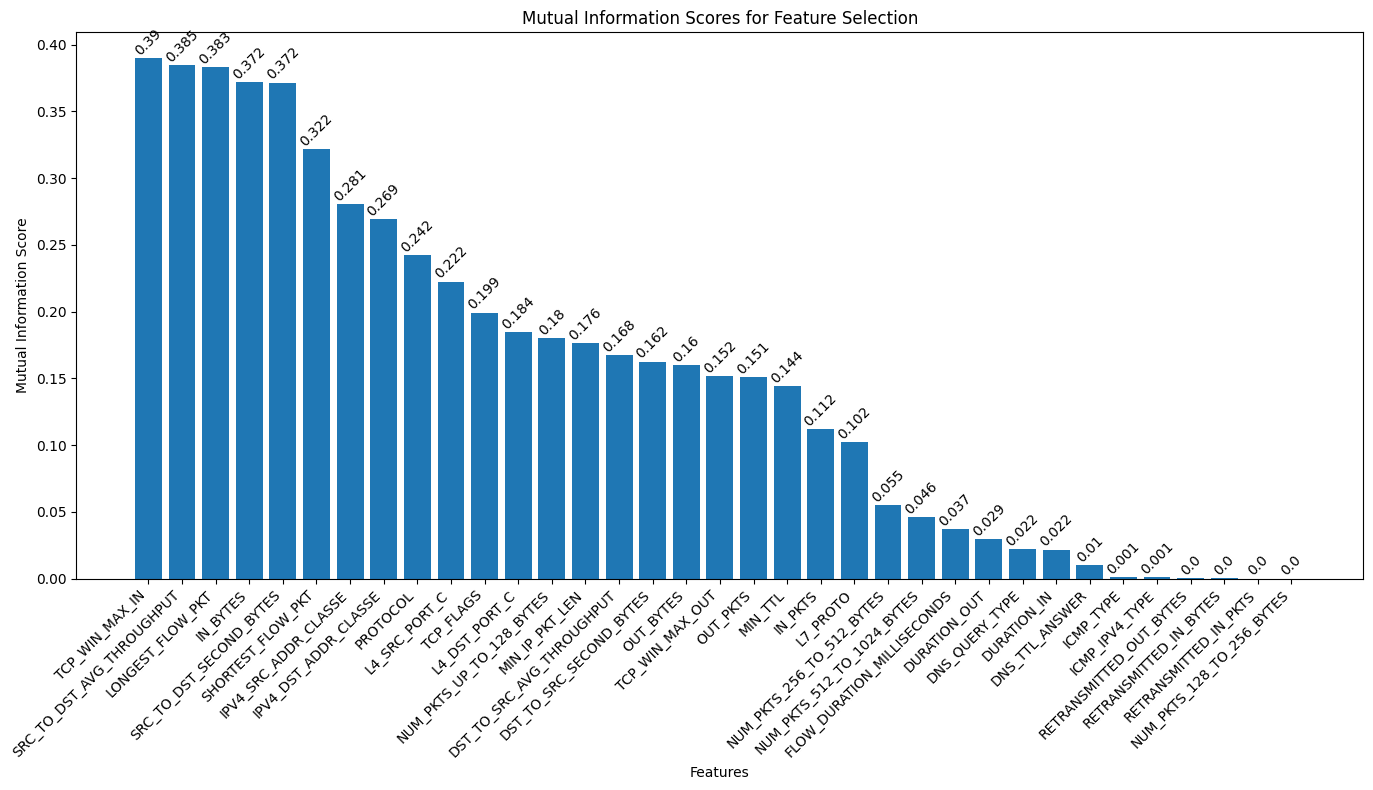

In [48]:
import matplotlib.pyplot as plt

mi_scores = -np.sort(-mi_class)
feature_names = columns_ranked_mi

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(feature_names)), mi_scores, align='center')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Scores for Feature Selection")

# Add MI score values at the top of each bar
for bar, score in zip(bars, mi_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 3),
             ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

## Plot feature score based on Chi2

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


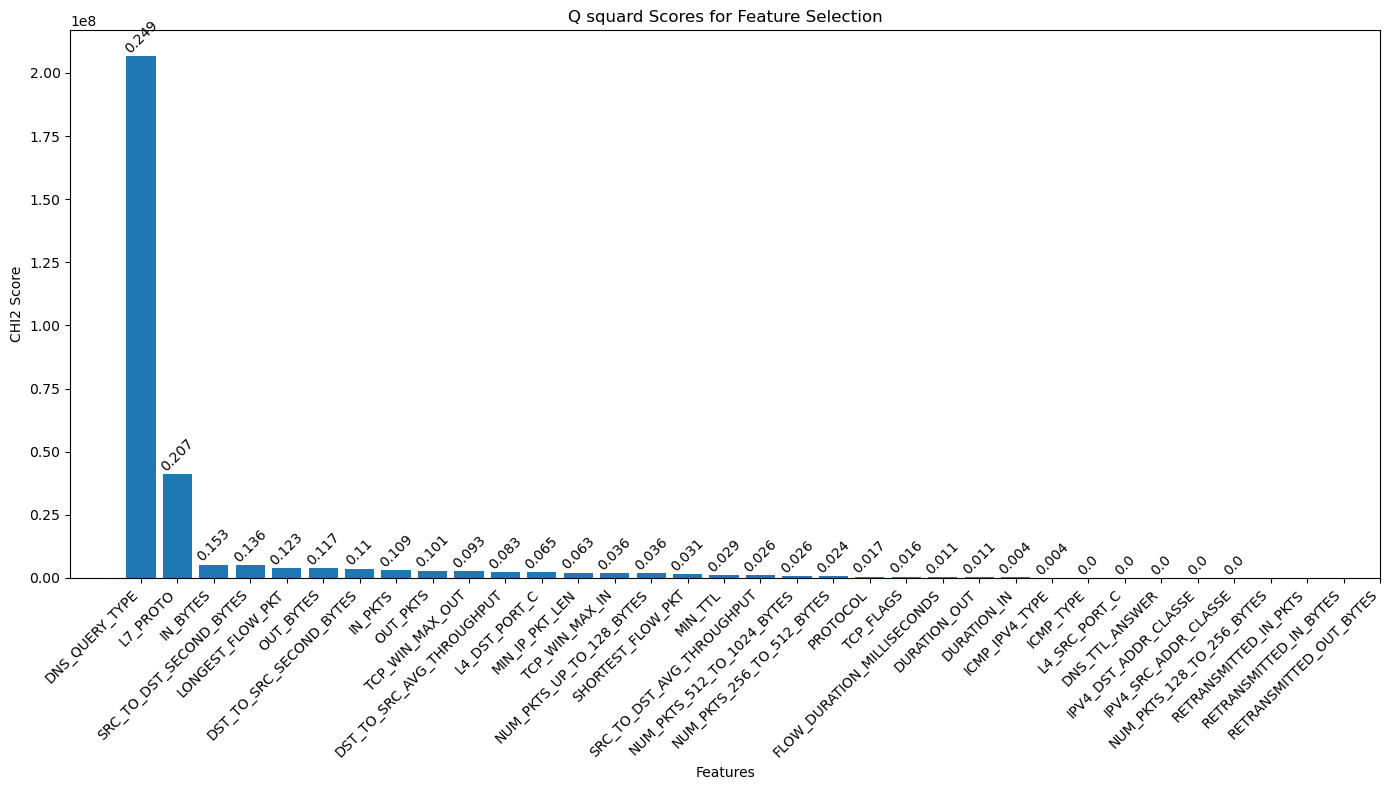

In [109]:
import matplotlib.pyplot as plt

chi2_scores = -np.sort(-chi2_corr[0])
feature_names_chi2 = columns_ranked_chi2

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(feature_names_chi2)), chi2_scores, align='center')
plt.xticks(range(len(feature_names_chi2)), feature_names_chi2, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("CHI2 Score")
plt.title("Q squard Scores for Feature Selection")

# Add MI score values at the top of each bar
for bar, score in zip(bars, mi_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 3),
             ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

In [105]:
import pickle

class Company(object):
    def __init__(self, name, value):
        self.name = name
        self.value = value

with open('attribute/ton_cat.pkl', 'wb') as outp:
    company1 = Company('mi_class', mi_class)
    pickle.dump(company1, outp, pickle.HIGHEST_PROTOCOL)

    company2 = Company('chi2_corr', chi2_corr)
    pickle.dump(company2, outp, pickle.HIGHEST_PROTOCOL)
    
    company3 = Company('selected_features_80', selected_features_80)
    pickle.dump(company3, outp, pickle.HIGHEST_PROTOCOL)


### Decision Tree

### MI

In [49]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [44]:
from sklearn import tree
from sklearn.model_selection import KFold
import json
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,cohen_kappa_score,matthews_corrcoef


def my_grid_result_df(clf,hyperparams,data_name,algo_name,X,y):
    
    scoring = {"Accuracy": "accuracy", "F1-Score":'f1' ,"Recall": 'recall',
               "Precision":"precision","MCC":make_scorer(matthews_corrcoef), "Kappa":make_scorer(cohen_kappa_score)}
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    search = GridSearchCV(clf, hyperparams, scoring=scoring, n_jobs=-1, cv=cv_inner, refit="MCC")
    grid_result = search.fit(X, y)

    json_dump = json.dumps(grid_result.cv_results_,cls=NumpyEncoder)
    # Serializing json

    # Writing to sample.json
    with open(f"./result/{algo_name}__{data_name}.json", "w") as outfile:
        outfile.write(json_dump)


In [45]:
datasets = {'X_chi2_20':X_chi2_20,
            'X_chi2_50':X_chi2_50,
            'X_chi2_80':X_chi2_80,
            'X_MI_20':X_MI_20,
            'X_MI_50':X_MI_50,
            'X_MI_80':X_MI_80,
            'X_mrmr_20':X_mrmr_20,
            'X_mrmr_50':X_mrmr_50,
            'X_mrmr_80':X_mrmr_80,
            'X':X}

NameError: name 'X_mrmr_20' is not defined

In [47]:
import datetime
def create_all_result(clf,algo_name,hyperparams,datasets,y):
    for k,v in datasets.items():
        now = datetime.datetime.now()
        print(f'======== process======= dataset : {k} \t time is {now}')
        my_grid_result_df(clf,hyperparams,k,algo_name,v,y)
        now = datetime.datetime.now()
        print(f'======== Done  ======== dataset : {k} \t time is {now}')
        print('\n')


# Decision Tree

In [55]:
clf = tree.DecisionTreeClassifier()
hyperparams = {}
create_all_result(clf,'DecisionTreeClassifier',hyperparams,datasets,y_b)

======== process======= dataset : X_chi2_20 	 time is 2023-03-03 09:44:13.481607
======== Done  ======== dataset : X_chi2_20 	 time is 2023-03-03 09:45:39.185274


======== process======= dataset : X_chi2_50 	 time is 2023-03-03 09:45:39.185274
======== Done  ======== dataset : X_chi2_50 	 time is 2023-03-03 09:48:53.954221


======== process======= dataset : X_chi2_80 	 time is 2023-03-03 09:48:53.954221
======== Done  ======== dataset : X_chi2_80 	 time is 2023-03-03 09:53:17.588356


======== process======= dataset : X_MI_20 	 time is 2023-03-03 09:53:17.588356
======== Done  ======== dataset : X_MI_20 	 time is 2023-03-03 09:54:15.463289


======== process======= dataset : X_MI_50 	 time is 2023-03-03 09:54:15.463289
======== Done  ======== dataset : X_MI_50 	 time is 2023-03-03 09:58:11.420203


======== process======= dataset : X_MI_80 	 time is 2023-03-03 09:58:11.420203
======== Done  ======== dataset : X_MI_80 	 time is 2023-03-03 10:03:43.221797


======== process======= data

In [47]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### AdaBoostClassifier, GradientBoostingClassifier


In [48]:
def print_skip():
    print('\n')
    print('*************** \t ******************* \t ****************')
    print('*************** \t ******************* \t ****************')
    print('\n')

In [40]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier
from xgboost import  XGBClassifier


clf = GradientBoostingClassifier(random_state=0)
hyperparams = {'n_estimators':[50, 100, 150,200]}

print('======================= GradientBoostingClassifier =====================')
create_all_result(clf,'GradientBoostingClassifier',hyperparams,datasets,y_b)
print_skip()

print('======================= AdaBoostClassifier =====================')
clf =  AdaBoostClassifier(random_state=0)
create_all_result(clf,'AdaBoostClassifier',hyperparams,datasets,y_b)
print_skip()


print('======================= XGBClassifier =====================')
clf = XGBClassifier(random_state=0)
create_all_result(clf,'XGBClassifier',hyperparams,datasets,y_b)
print_skip()

print('======================= LGBMClassifier =====================')
clf = LGBMClassifier(random_state=0)
create_all_result(clf,'LGBMClassifier',hyperparams,datasets,y_b)
print_skip()

print('======================= CatBoostClassifier =====================')
clf =  CatBoostClassifier(random_state=0)
create_all_result(clf,'CatBoostClassifier',hyperparams,datasets,y_b)


======================= GradientBoostingClassifier =====================
======== process======= dataset : X_chi2_20 	 time is 2023-03-02 19:09:53.437066
======== Done  ======== dataset : X_chi2_20 	 time is 2023-03-02 20:43:36.408688


======== process======= dataset : X_chi2_50 	 time is 2023-03-02 20:43:36.408688
======== Done  ======== dataset : X_chi2_50 	 time is 2023-03-02 23:53:18.977951


======== process======= dataset : X_chi2_80 	 time is 2023-03-02 23:53:18.977951
======== Done  ======== dataset : X_chi2_80 	 time is 2023-03-03 03:49:57.804862


======== process======= dataset : X_MI_20 	 time is 2023-03-03 03:49:57.804862
======== Done  ======== dataset : X_MI_20 	 time is 2023-03-03 05:06:43.497073


======== process======= dataset : X_MI_50 	 time is 2023-03-03 05:06:43.497073
======== Done  ======== dataset : X_MI_50 	 time is 2023-03-03 08:51:33.322077


======== process======= dataset : X_MI_80 	 time is 2023-03-03 08:51:33.322077


KeyboardInterrupt: 

In [44]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier
from xgboost import  XGBClassifier

hyperparams = {'n_estimators':[50, 100, 150,200]}
print('======================= CatBoostClassifier =====================')
clf =  CatBoostClassifier(random_state=0)
create_all_result(clf,'CatBoostClassifier',hyperparams,datasets,y_b)

======================= CatBoostClassifier =====================
======== process======= dataset : X_chi2_20 	 time is 2023-03-06 10:07:57.468473
Learning rate set to 0.5
0:	learn: 0.2993644	total: 1.41s	remaining: 4m 40s
1:	learn: 0.2321203	total: 2.29s	remaining: 3m 47s
2:	learn: 0.2025491	total: 3.2s	remaining: 3m 30s
3:	learn: 0.1929616	total: 4.01s	remaining: 3m 16s
4:	learn: 0.1868980	total: 4.8s	remaining: 3m 7s
5:	learn: 0.1777385	total: 5.59s	remaining: 3m
6:	learn: 0.1730869	total: 6.48s	remaining: 2m 58s
7:	learn: 0.1673064	total: 7.34s	remaining: 2m 56s
8:	learn: 0.1647891	total: 8.11s	remaining: 2m 52s
9:	learn: 0.1626140	total: 9.09s	remaining: 2m 52s
10:	learn: 0.1606432	total: 9.95s	remaining: 2m 50s
11:	learn: 0.1588154	total: 10.7s	remaining: 2m 48s
12:	learn: 0.1579487	total: 11.7s	remaining: 2m 47s
13:	learn: 0.1562360	total: 12.6s	remaining: 2m 47s
14:	learn: 0.1547361	total: 13.4s	remaining: 2m 45s
15:	learn: 0.1520041	total: 14.3s	remaining: 2m 44s
16:	learn: 0.1

154:	learn: 0.1404150	total: 2m 11s	remaining: 38.1s
155:	learn: 0.1403979	total: 2m 11s	remaining: 37.2s
156:	learn: 0.1403956	total: 2m 12s	remaining: 36.4s
157:	learn: 0.1403970	total: 2m 13s	remaining: 35.5s
158:	learn: 0.1403974	total: 2m 14s	remaining: 34.7s
159:	learn: 0.1403850	total: 2m 15s	remaining: 33.9s
160:	learn: 0.1403818	total: 2m 16s	remaining: 33s
161:	learn: 0.1403758	total: 2m 17s	remaining: 32.2s
162:	learn: 0.1403752	total: 2m 18s	remaining: 31.3s
163:	learn: 0.1403752	total: 2m 18s	remaining: 30.5s
164:	learn: 0.1403691	total: 2m 19s	remaining: 29.6s
165:	learn: 0.1403685	total: 2m 20s	remaining: 28.8s
166:	learn: 0.1403662	total: 2m 21s	remaining: 27.9s
167:	learn: 0.1403666	total: 2m 22s	remaining: 27.1s
168:	learn: 0.1403619	total: 2m 22s	remaining: 26.2s
169:	learn: 0.1403620	total: 2m 23s	remaining: 25.3s
170:	learn: 0.1403619	total: 2m 24s	remaining: 24.5s
171:	learn: 0.1403565	total: 2m 25s	remaining: 23.6s
172:	learn: 0.1403568	total: 2m 25s	remaining: 2

108:	learn: 0.0674878	total: 1m 39s	remaining: 1m 22s
109:	learn: 0.0674690	total: 1m 40s	remaining: 1m 21s
110:	learn: 0.0674622	total: 1m 41s	remaining: 1m 21s
111:	learn: 0.0674267	total: 1m 41s	remaining: 1m 20s
112:	learn: 0.0674167	total: 1m 42s	remaining: 1m 19s
113:	learn: 0.0674005	total: 1m 43s	remaining: 1m 18s
114:	learn: 0.0673865	total: 1m 44s	remaining: 1m 17s
115:	learn: 0.0673659	total: 1m 45s	remaining: 1m 16s
116:	learn: 0.0673650	total: 1m 46s	remaining: 1m 15s
117:	learn: 0.0673563	total: 1m 47s	remaining: 1m 14s
118:	learn: 0.0673561	total: 1m 47s	remaining: 1m 13s
119:	learn: 0.0673182	total: 1m 48s	remaining: 1m 12s
120:	learn: 0.0672932	total: 1m 49s	remaining: 1m 11s
121:	learn: 0.0672750	total: 1m 50s	remaining: 1m 10s
122:	learn: 0.0672758	total: 1m 51s	remaining: 1m 9s
123:	learn: 0.0672625	total: 1m 52s	remaining: 1m 8s
124:	learn: 0.0672217	total: 1m 53s	remaining: 1m 7s
125:	learn: 0.0671961	total: 1m 54s	remaining: 1m 7s
126:	learn: 0.0671923	total: 1m 

62:	learn: 0.0432855	total: 58s	remaining: 2m 6s
63:	learn: 0.0432658	total: 58.8s	remaining: 2m 4s
64:	learn: 0.0432257	total: 59.5s	remaining: 2m 3s
65:	learn: 0.0432004	total: 1m	remaining: 2m 2s
66:	learn: 0.0431483	total: 1m 1s	remaining: 2m 2s
67:	learn: 0.0430718	total: 1m 2s	remaining: 2m 1s
68:	learn: 0.0430276	total: 1m 3s	remaining: 2m
69:	learn: 0.0429635	total: 1m 4s	remaining: 1m 59s
70:	learn: 0.0429319	total: 1m 5s	remaining: 1m 58s
71:	learn: 0.0428381	total: 1m 6s	remaining: 1m 57s
72:	learn: 0.0428058	total: 1m 7s	remaining: 1m 56s
73:	learn: 0.0427626	total: 1m 7s	remaining: 1m 55s
74:	learn: 0.0427456	total: 1m 8s	remaining: 1m 54s
75:	learn: 0.0427223	total: 1m 9s	remaining: 1m 53s
76:	learn: 0.0426975	total: 1m 10s	remaining: 1m 52s
77:	learn: 0.0426712	total: 1m 11s	remaining: 1m 51s
78:	learn: 0.0426247	total: 1m 12s	remaining: 1m 50s
79:	learn: 0.0426048	total: 1m 12s	remaining: 1m 49s
80:	learn: 0.0425785	total: 1m 13s	remaining: 1m 48s
81:	learn: 0.0425596	t

15:	learn: 0.2043809	total: 14.6s	remaining: 2m 48s
16:	learn: 0.2040851	total: 15.5s	remaining: 2m 47s
17:	learn: 0.2037624	total: 16.4s	remaining: 2m 46s
18:	learn: 0.2034787	total: 17.4s	remaining: 2m 46s
19:	learn: 0.2030617	total: 18.3s	remaining: 2m 44s
20:	learn: 0.2027136	total: 19.3s	remaining: 2m 44s
21:	learn: 0.2017155	total: 20.1s	remaining: 2m 42s
22:	learn: 0.2015722	total: 21.1s	remaining: 2m 42s
23:	learn: 0.2011074	total: 21.9s	remaining: 2m 40s
24:	learn: 0.2008923	total: 22.8s	remaining: 2m 39s
25:	learn: 0.2008405	total: 23.6s	remaining: 2m 37s
26:	learn: 0.2007094	total: 24.5s	remaining: 2m 36s
27:	learn: 0.2005298	total: 25.4s	remaining: 2m 35s
28:	learn: 0.2003417	total: 26.3s	remaining: 2m 35s
29:	learn: 0.2001169	total: 27.1s	remaining: 2m 33s
30:	learn: 0.1999278	total: 27.9s	remaining: 2m 32s
31:	learn: 0.1998184	total: 28.8s	remaining: 2m 31s
32:	learn: 0.1996778	total: 29.7s	remaining: 2m 30s
33:	learn: 0.1994364	total: 30.5s	remaining: 2m 28s
34:	learn: 0

172:	learn: 0.1974667	total: 2m 26s	remaining: 22.8s
173:	learn: 0.1974670	total: 2m 26s	remaining: 22s
174:	learn: 0.1974672	total: 2m 27s	remaining: 21.1s
175:	learn: 0.1974671	total: 2m 28s	remaining: 20.3s
176:	learn: 0.1974671	total: 2m 29s	remaining: 19.4s
177:	learn: 0.1974655	total: 2m 30s	remaining: 18.6s
178:	learn: 0.1974661	total: 2m 30s	remaining: 17.7s
179:	learn: 0.1974661	total: 2m 31s	remaining: 16.9s
180:	learn: 0.1974679	total: 2m 32s	remaining: 16s
181:	learn: 0.1974655	total: 2m 33s	remaining: 15.2s
182:	learn: 0.1974662	total: 2m 34s	remaining: 14.3s
183:	learn: 0.1974662	total: 2m 34s	remaining: 13.5s
184:	learn: 0.1974180	total: 2m 35s	remaining: 12.6s
185:	learn: 0.1974180	total: 2m 36s	remaining: 11.8s
186:	learn: 0.1974180	total: 2m 37s	remaining: 10.9s
187:	learn: 0.1974180	total: 2m 37s	remaining: 10.1s
188:	learn: 0.1974180	total: 2m 38s	remaining: 9.24s
189:	learn: 0.1974180	total: 2m 39s	remaining: 8.39s
190:	learn: 0.1974180	total: 2m 40s	remaining: 7.5

126:	learn: 0.0688983	total: 1m 50s	remaining: 1m 3s
127:	learn: 0.0688983	total: 1m 51s	remaining: 1m 2s
128:	learn: 0.0688983	total: 1m 52s	remaining: 1m 1s
129:	learn: 0.0688983	total: 1m 53s	remaining: 1m
130:	learn: 0.0688983	total: 1m 54s	remaining: 1m
131:	learn: 0.0688983	total: 1m 54s	remaining: 59.1s
132:	learn: 0.0688983	total: 1m 55s	remaining: 58.2s
133:	learn: 0.0688983	total: 1m 56s	remaining: 57.3s
134:	learn: 0.0688983	total: 1m 57s	remaining: 56.4s
135:	learn: 0.0688983	total: 1m 57s	remaining: 55.5s
136:	learn: 0.0688983	total: 1m 58s	remaining: 54.6s
137:	learn: 0.0688983	total: 1m 59s	remaining: 53.7s
138:	learn: 0.0688983	total: 2m	remaining: 52.8s
139:	learn: 0.0688983	total: 2m	remaining: 51.8s
140:	learn: 0.0688983	total: 2m 1s	remaining: 50.9s
141:	learn: 0.0688983	total: 2m 2s	remaining: 50.1s
142:	learn: 0.0688983	total: 2m 3s	remaining: 49.2s
143:	learn: 0.0688983	total: 2m 4s	remaining: 48.3s
144:	learn: 0.0688983	total: 2m 4s	remaining: 47.4s
145:	learn: 

81:	learn: 0.0432897	total: 1m 15s	remaining: 1m 48s
82:	learn: 0.0432663	total: 1m 16s	remaining: 1m 47s
83:	learn: 0.0432571	total: 1m 17s	remaining: 1m 46s
84:	learn: 0.0432208	total: 1m 18s	remaining: 1m 45s
85:	learn: 0.0432020	total: 1m 19s	remaining: 1m 44s
86:	learn: 0.0431872	total: 1m 20s	remaining: 1m 44s
87:	learn: 0.0431603	total: 1m 21s	remaining: 1m 43s
88:	learn: 0.0431603	total: 1m 21s	remaining: 1m 42s
89:	learn: 0.0431603	total: 1m 22s	remaining: 1m 41s
90:	learn: 0.0431603	total: 1m 23s	remaining: 1m 39s
91:	learn: 0.0431603	total: 1m 24s	remaining: 1m 38s
92:	learn: 0.0431603	total: 1m 25s	remaining: 1m 37s
93:	learn: 0.0431603	total: 1m 25s	remaining: 1m 36s
94:	learn: 0.0431603	total: 1m 26s	remaining: 1m 35s
95:	learn: 0.0431603	total: 1m 27s	remaining: 1m 34s
96:	learn: 0.0431603	total: 1m 28s	remaining: 1m 33s
97:	learn: 0.0431603	total: 1m 29s	remaining: 1m 32s
98:	learn: 0.0431603	total: 1m 29s	remaining: 1m 31s
99:	learn: 0.0431603	total: 1m 30s	remaining: 

34:	learn: 0.2178872	total: 30.9s	remaining: 2m 25s
35:	learn: 0.2178457	total: 31.8s	remaining: 2m 24s
36:	learn: 0.2178359	total: 32.7s	remaining: 2m 23s
37:	learn: 0.2178069	total: 33.4s	remaining: 2m 22s
38:	learn: 0.2177782	total: 34.4s	remaining: 2m 21s
39:	learn: 0.2177504	total: 35.1s	remaining: 2m 20s
40:	learn: 0.2177537	total: 36.1s	remaining: 2m 19s
41:	learn: 0.2176981	total: 37s	remaining: 2m 19s
42:	learn: 0.2176757	total: 37.9s	remaining: 2m 18s
43:	learn: 0.2176700	total: 38.8s	remaining: 2m 17s
44:	learn: 0.2176240	total: 39.7s	remaining: 2m 16s
45:	learn: 0.2176013	total: 40.7s	remaining: 2m 16s
46:	learn: 0.2175973	total: 41.5s	remaining: 2m 15s
47:	learn: 0.2175908	total: 42.3s	remaining: 2m 14s
48:	learn: 0.2175701	total: 43.2s	remaining: 2m 13s
49:	learn: 0.2175679	total: 44s	remaining: 2m 12s
50:	learn: 0.2175575	total: 44.9s	remaining: 2m 11s
51:	learn: 0.2175388	total: 45.6s	remaining: 2m 9s
52:	learn: 0.2175257	total: 46.5s	remaining: 2m 8s
53:	learn: 0.21756

191:	learn: 0.2173679	total: 2m 36s	remaining: 6.54s
192:	learn: 0.2173680	total: 2m 37s	remaining: 5.72s
193:	learn: 0.2173679	total: 2m 38s	remaining: 4.9s
194:	learn: 0.2173688	total: 2m 39s	remaining: 4.08s
195:	learn: 0.2173693	total: 2m 39s	remaining: 3.26s
196:	learn: 0.2173672	total: 2m 40s	remaining: 2.45s
197:	learn: 0.2173672	total: 2m 41s	remaining: 1.63s
198:	learn: 0.2173666	total: 2m 42s	remaining: 816ms
199:	learn: 0.2173659	total: 2m 43s	remaining: 0us
======== Done  ======== dataset : X_mrmr_20 	 time is 2023-03-06 11:52:07.655768


======== process======= dataset : X_mrmr_50 	 time is 2023-03-06 11:52:07.655768
Learning rate set to 0.5
0:	learn: 0.2514741	total: 1.38s	remaining: 4m 34s
1:	learn: 0.1702892	total: 2.35s	remaining: 3m 53s
2:	learn: 0.1471530	total: 3.21s	remaining: 3m 30s
3:	learn: 0.1361310	total: 4.21s	remaining: 3m 26s
4:	learn: 0.1297342	total: 5.06s	remaining: 3m 17s
5:	learn: 0.1253518	total: 6.04s	remaining: 3m 15s
6:	learn: 0.1212195	total: 7.01

145:	learn: 0.0994235	total: 2m 10s	remaining: 48.4s
146:	learn: 0.0994235	total: 2m 11s	remaining: 47.5s
147:	learn: 0.0994235	total: 2m 12s	remaining: 46.5s
148:	learn: 0.0994235	total: 2m 13s	remaining: 45.6s
149:	learn: 0.0994235	total: 2m 14s	remaining: 44.7s
150:	learn: 0.0994235	total: 2m 14s	remaining: 43.8s
151:	learn: 0.0993996	total: 2m 15s	remaining: 42.9s
152:	learn: 0.0994004	total: 2m 16s	remaining: 41.9s
153:	learn: 0.0993755	total: 2m 17s	remaining: 41s
154:	learn: 0.0993755	total: 2m 18s	remaining: 40.1s
155:	learn: 0.0993755	total: 2m 19s	remaining: 39.2s
156:	learn: 0.0993618	total: 2m 19s	remaining: 38.3s
157:	learn: 0.0993437	total: 2m 20s	remaining: 37.4s
158:	learn: 0.0993436	total: 2m 21s	remaining: 36.5s
159:	learn: 0.0993426	total: 2m 22s	remaining: 35.6s
160:	learn: 0.0993438	total: 2m 23s	remaining: 34.7s
161:	learn: 0.0993345	total: 2m 24s	remaining: 33.8s
162:	learn: 0.0993164	total: 2m 25s	remaining: 33s
163:	learn: 0.0993108	total: 2m 26s	remaining: 32.

99:	learn: 0.0418365	total: 1m 30s	remaining: 1m 30s
100:	learn: 0.0418156	total: 1m 31s	remaining: 1m 29s
101:	learn: 0.0417882	total: 1m 31s	remaining: 1m 28s
102:	learn: 0.0417607	total: 1m 32s	remaining: 1m 27s
103:	learn: 0.0416712	total: 1m 33s	remaining: 1m 26s
104:	learn: 0.0416711	total: 1m 34s	remaining: 1m 25s
105:	learn: 0.0416710	total: 1m 35s	remaining: 1m 24s
106:	learn: 0.0416710	total: 1m 36s	remaining: 1m 23s
107:	learn: 0.0416711	total: 1m 36s	remaining: 1m 22s
108:	learn: 0.0416285	total: 1m 37s	remaining: 1m 21s
109:	learn: 0.0416130	total: 1m 38s	remaining: 1m 20s
110:	learn: 0.0415859	total: 1m 39s	remaining: 1m 19s
111:	learn: 0.0415623	total: 1m 40s	remaining: 1m 18s
112:	learn: 0.0415538	total: 1m 41s	remaining: 1m 18s
113:	learn: 0.0415538	total: 1m 42s	remaining: 1m 17s
114:	learn: 0.0415412	total: 1m 43s	remaining: 1m 16s
115:	learn: 0.0415208	total: 1m 44s	remaining: 1m 15s
116:	learn: 0.0414927	total: 1m 45s	remaining: 1m 14s
117:	learn: 0.0414740	total: 

53:	learn: 0.0401015	total: 50.6s	remaining: 2m 16s
54:	learn: 0.0400787	total: 51.4s	remaining: 2m 15s
55:	learn: 0.0400097	total: 52.4s	remaining: 2m 14s
56:	learn: 0.0398974	total: 53.4s	remaining: 2m 13s
57:	learn: 0.0398506	total: 54.4s	remaining: 2m 13s
58:	learn: 0.0398117	total: 55.3s	remaining: 2m 12s
59:	learn: 0.0397569	total: 56.2s	remaining: 2m 11s
60:	learn: 0.0396934	total: 57.2s	remaining: 2m 10s
61:	learn: 0.0396581	total: 58.1s	remaining: 2m 9s
62:	learn: 0.0396284	total: 59s	remaining: 2m 8s
63:	learn: 0.0395980	total: 59.9s	remaining: 2m 7s
64:	learn: 0.0395665	total: 1m	remaining: 2m 6s
65:	learn: 0.0395115	total: 1m 1s	remaining: 2m 5s
66:	learn: 0.0395115	total: 1m 2s	remaining: 2m 4s
67:	learn: 0.0394840	total: 1m 3s	remaining: 2m 3s
68:	learn: 0.0394016	total: 1m 4s	remaining: 2m 2s
69:	learn: 0.0393812	total: 1m 5s	remaining: 2m 1s
70:	learn: 0.0393275	total: 1m 6s	remaining: 2m
71:	learn: 0.0392509	total: 1m 7s	remaining: 1m 59s
72:	learn: 0.0392232	total: 1m

## Save the model as pickel for future deployment 

'X_chi2_20':X_chi2_20,
'X_chi2_50':X_chi2_50,
'X_chi2_80':X_chi2_80,
'X_MI_20':X_MI_20,
'X_MI_50':X_MI_50,
'X_MI_80':X_MI_80,
'X_mrmr_20':X_mrmr_20,
'X_mrmr_50':X_mrmr_50,
'X_mrmr_80':X_mrmr_80,
'X':X

In [56]:

# Best Model using  descritization  20 Chi2+XGB_200 X_chi2_20 ||| 50 Chi2+XGB_200   X_chi2_50 ||  80 mRMR+XGB_200  X_mrmr_80  ||  100 XGB_200  X

import xgboost as xgb

# Train your model (example)
model = xgb.XGBClassifier(n_estimators=200)
model.fit(X_mrmr_80, y_b)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [57]:
import joblib

# Save
joblib.dump(model, "XGB_200_mRMR_80.pkl")

['XGB_200_mRMR_80.pkl']

In [ ]:
print(list(X.iloc[0].values))
print(list(X.iloc[345].values))
print(list(X.iloc[6546].values))
print(list(X.iloc[23].values))
print(list(X.iloc[87].values))
print(list(X.iloc[9].values))
print(list(X.iloc[678].values))
print(list(X.iloc[0].values))
print(list(X.iloc[235].values))
print(list(X.iloc[98].values))